# BATCH LERANING
we will do some batch model in order to compare our online results.

In [35]:
#!pip install plotly/ à install befor
import pandas as pd
import math
import os.path
import time
import numpy as np

import seaborn as sb
from datetime import timedelta, datetime
from dateutil import parser
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as py
import matplotlib.pyplot as plt
#necessary imports:

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import LinearSVR

In [36]:
#read the data set adapte the directory
df=pd.read_csv('bitcoin.csv',sep=",",parse_dates=True)
df

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,nb_trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2023-01-11 20:45:00,17530.60,17530.73,17525.26,17528.02,190.58561,1.673470e+12,3.340573e+06,3384.0,99.64006,1.746509e+06,0.0
1,2023-01-11 20:46:00,17528.01,17533.08,17524.52,17529.25,131.65110,1.673470e+12,2.307722e+06,3191.0,70.96141,1.243909e+06,0.0
2,2023-01-11 20:47:00,17528.92,17535.00,17527.06,17529.31,136.71343,1.673470e+12,2.396620e+06,2840.0,78.42198,1.374760e+06,0.0
3,2023-01-11 20:48:00,17529.53,17533.00,17528.26,17528.58,130.10384,1.673470e+12,2.280868e+06,2603.0,60.41718,1.059216e+06,0.0
4,2023-01-11 20:49:00,17529.00,17535.32,17528.50,17534.56,120.92813,1.673470e+12,2.120177e+06,2943.0,78.37365,1.374095e+06,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,2023-01-12 13:20:00,18252.20,18257.05,18246.76,18247.43,206.11351,1.673530e+12,3.761795e+06,6230.0,90.12643,1.644928e+06,0.0
996,2023-01-12 13:21:00,18247.43,18248.00,18215.65,18220.09,601.06591,1.673530e+12,1.095738e+07,11806.0,265.53206,4.840804e+06,0.0
997,2023-01-12 13:22:00,18220.09,18228.15,18206.40,18211.76,426.57337,1.673530e+12,7.770362e+06,11332.0,206.95374,3.769865e+06,0.0
998,2023-01-12 13:23:00,18211.77,18220.67,18194.96,18209.88,504.83179,1.673530e+12,9.191151e+06,10650.0,217.93879,3.968019e+06,0.0


In [39]:

# put the open in time type pandas
df['open_time'] = pd.to_datetime(df['open_time']) 
df['close_time'] = pd.to_datetime(df['close_time'])


In [41]:
# set the index
df=df.set_index('open_time')

In [86]:
# plot the price close
config={'text': 'visualization of price Value'}
fig = go.Figure(data=[go.Scatter(x=df.index, y=df['close'])])

fig.update_layout(title = config , template="plotly_white") ##Available templates:['ggplot2', 'seaborn', 'simple_white', 'plotly','plotly_white', 'plotly_dark', 'presentation', 'xgridoff','ygridoff', 'gridon', 'none']

fig.show()

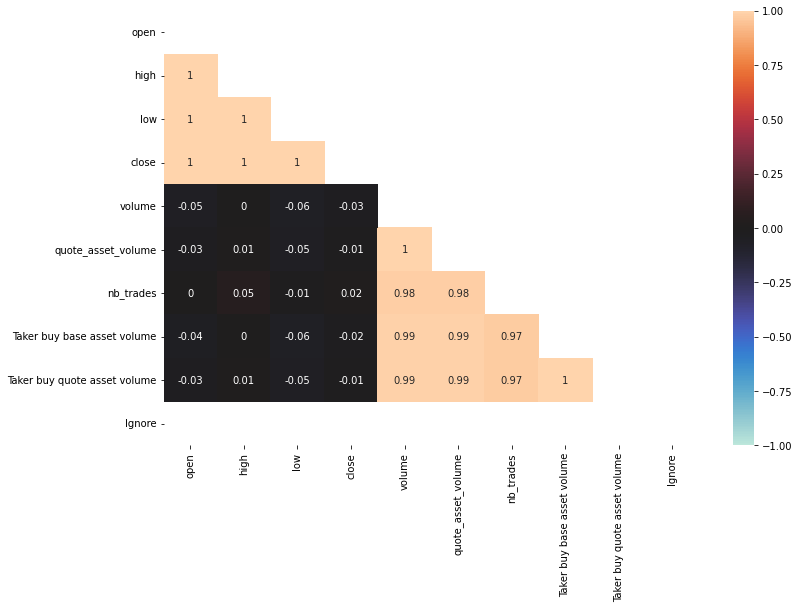

In [43]:
# show the correlation in the dataset
plt.figure(figsize=(12, 8))
matrix = df.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sb.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, mask=mask)

plt.show()

We observe some correlation withe the close price data so these features can allow to predict the price.

In [44]:
# we have to split ou dataset
close_price = df['close']
train_data=df[0:int(len(df["close"])*0.75)]
test_data=df[int(len(df["close"])*0.75):]

close_train=train_data['close']
close_test=test_data['close']
train_data.shape, test_data.shape

((750, 11), (250, 11))

In [45]:
def Vect(train,test,timestamp):
    X_train,X_test=np.zeros((len(train)-timestamp,timestamp)),np.zeros((len(test)-timestamp,timestamp))
    y_train,y_test=np.array(train[timestamp:]),np.array(test[timestamp:]) #The first element will need the 'timestamp' previous values
     # loop through the train data:
    for i in range(timestamp,len(train)):
        Xtrain=train[i-timestamp:i]
        if len(Xtrain)==timestamp:
            X_train[i-timestamp,:] = np.array(Xtrain).reshape((timestamp,))
    for i in range(timestamp,len(test)):
        Xtest=test[i-timestamp:i]
        if len(Xtest)==timestamp:
            X_test[i-timestamp,:] = np.array(Xtest).reshape((timestamp,))
    return X_train,X_test,y_train,y_test

In [46]:
timestamp=10
X_train,X_test,y_train,y_test=Vect(close_train,close_test,10)

In [93]:
LinReg = LinearRegression()
#Initializing the RandomForestRegressor
RandomForest = RandomForestRegressor(max_depth=5, n_estimators=100)
#in order to simlify the task we are going to create a dictionnary to map each model to a name
models = {"Linear Regression":LinReg,  "Random Forest Regressor":RandomForest}

In [57]:
# define to remove the features 'Ignore
X_train[0:10]
XTRAIN=np.array([np.array(xi) for xi in X_train])
XTRAIN.ndim
XTRAIN.reshape(-1, XTRAIN.shape[-1])
XTRAIN.shape

(740, 10)

In [58]:
training=train_data.copy()
testing=test_data.copy()
training.drop(training.columns.difference(['close']), 1, inplace=True)
#training["scaled_close"]=scaler.fit_transform(training)
training = training.iloc[timestamp: , :]
testing.drop(testing.columns.difference(['close']), 1, inplace=True)
#testing["scaled_close"]=scaler.fit_transform(testing)
testing = testing.iloc[timestamp: , :]
#prediction=pd.DataFrame()
#prediction=[pd.DataFrame(),pd.DataFrame(test_data.iloc[timestamp:,3])]
#type(train_data.iloc[timestamp:,3])
print("shape of train:",training.shape)
print("shape of test:",testing.shape)
prediction=[training,testing]
prediction=pd.concat(prediction)
print("shape of join:",prediction.shape)

shape of train: (740, 1)
shape of test: (240, 1)
shape of join: (980, 1)


<ipython-input-58-1a4d97ea44fd>:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

<ipython-input-58-1a4d97ea44fd>:6: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [94]:
# Let's create a function that train all the models above
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def training(model):
    models[model].fit(X_train,y_train)
    y_pred_test = models[model].predict(X_test)
    y_pred_train = models[model].predict(X_train)
    prediction[model]=np.concatenate((y_pred_train,y_pred_test), axis=0)
    print("\n---------------"+model+"---------------\n")
    print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, y_pred_test)))
    print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, y_pred_test)))+"\n")
    return (mean_absolute_error(y_test, y_pred_test),math.sqrt(mean_squared_error(y_test, y_pred_test)))

In [95]:
# Now we are going to train the models:
i=1
MSE=[]
MAE=[]
for model in models:
    
    print(i)
    metrics=training(model)
    MSE.append(metrics[1])
    MAE.append(metrics[0])
    i=i+1
results=[MSE,MAE]
models_results=pd.DataFrame(results,columns=models.keys(),index =['MSE','MAE'])

1

---------------Linear Regression---------------

Mean Absolute Error - MAE : 5.503723867058867
Root Mean squared Error - RMSE : 7.987777060440496

2

---------------Random Forest Regressor---------------

Mean Absolute Error - MAE : 7.5997723353121724
Root Mean squared Error - RMSE : 9.728167488116638



In [96]:
# plot the RMSE of the model
models_results

,Linear Regression,Random Forest Regressor
MSE,7.987777,9.728167
MAE,5.503724,7.599772


In [91]:
# do the prediction
prediction.head()

,close,Linear Regression,Random Forest Regressor,Ridge Regressor
open_time,,,,
2023-01-11 20:55:00,17549.10,17545.243730,17542.232076,17545.243734
2023-01-11 20:56:00,17542.39,17553.852143,17548.259438,17553.852062
2023-01-11 20:57:00,17544.99,17542.203918,17542.442153,17542.204099
2023-01-11 20:58:00,17539.02,17548.505111,17544.901912,17548.505049
2023-01-11 20:59:00,17550.57,17541.848635,17540.283782,17541.848709


In [98]:
# plot the model
for model in models.keys():
    fig = px.line(prediction,x=prediction.index, y=[prediction['close'],prediction[model]],
                  labels={'value':'Close price','date': 'Date'},width=800, height=300)
    fig.update_layout(title_text='Prediction avec le '+model,
                      font_size=8,legend_title_text='Close Price',margin=dict(l=20, r=20, t=20, b=20),paper_bgcolor="LightSteelBlue")
    #fig.add_trace(go.Scatter(mode="markers", x=df["Date"], y=df["AAPL.Close"], name="daily"))
    fig.show()